In [10]:
# Imports & basic config
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Paths
THIS_DIR   = Path.cwd()          # assume we're in visualization/
ROOT_DIR   = THIS_DIR.parent     # repo root
RESULTS_DIR = ROOT_DIR / "results"

FIG_DIR = THIS_DIR / "figures" / "baseline_vs_unet"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Friendly labels → sub-folder names inside results/
MODELS = {
    "Best UNet": "best_unet",
    "Linear":    "linear_baseline",
    "MLP":       "mlp_baseline",
    "CNN":       "cnn_baseline",
}

print("Figures will be saved to:", FIG_DIR.relative_to(ROOT_DIR))



Figures will be saved to: visualization/figures/baseline_vs_unet


In [11]:
def load_metrics(folder_name: str) -> pd.DataFrame:
    csv_path = RESULTS_DIR / folder_name / "metrics.csv"
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)
    return pd.read_csv(csv_path)

def get_val_row(df: pd.DataFrame) -> pd.Series:
    """
    Return the last *numeric* epoch row (e.g. 19) that still contains
    training/validation columns.
    """
    if "epoch" not in df.columns:
        return df.iloc[-2]         # fallback: 2nd-to-last row
    numeric_mask = pd.to_numeric(df["epoch"], errors="coerce").notna()
    return df[numeric_mask].iloc[-1]

def get_test_row(df: pd.DataFrame) -> pd.Series:
    """Return the dedicated 'test' row (or last row fallback)."""
    if "epoch" in df.columns and (df["epoch"] == "test").any():
        return df[df["epoch"] == "test"].iloc[0]
    return df.iloc[-1]

# -- load every model once --
RAW_LOGS  = {k: load_metrics(v) for k, v in MODELS.items()}
VAL_ROWS  = {k: get_val_row(df) for k, df in RAW_LOGS.items()}
TEST_ROWS = {k: get_test_row(df) for k, df in RAW_LOGS.items()}

# quick sanity-check
pd.DataFrame({
    "test/tas/rmse": [TEST_ROWS[k]["test/tas/rmse"] for k in MODELS],
    "val/tas/rmse":  [VAL_ROWS[k]["val/tas/rmse"]   for k in MODELS],
}, index=list(MODELS))


,test/tas/rmse,val/tas/rmse
Best UNet,291.104980,1.914860
Linear,284.304871,12.753673
MLP,282.642456,11.054799
CNN,292.487823,5.670803


Saved → visualization/figures/baseline_vs_unet/bar_final_test_rmse.png


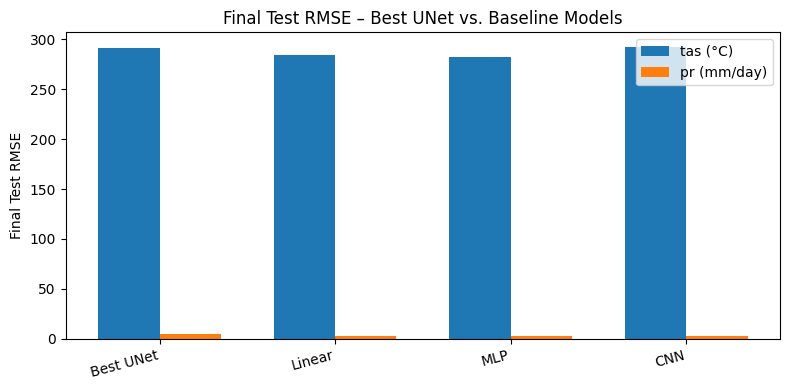

In [12]:
labels        = list(MODELS.keys())
tas_test_rmse = [TEST_ROWS[l]["test/tas/rmse"] for l in labels]
pr_test_rmse  = [TEST_ROWS[l]["test/pr/rmse"]  for l in labels]

x = range(len(labels)); w = 0.35
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([i - w/2 for i in x], tas_test_rmse, width=w, label="tas (°C)")
ax.bar([i + w/2 for i in x], pr_test_rmse,  width=w, label="pr (mm/day)")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("Final Test RMSE")
ax.set_title("Final Test RMSE – Best UNet vs. Baseline Models")
ax.legend(); fig.tight_layout()

save_path = FIG_DIR / "bar_final_test_rmse.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()



Saved → visualization/figures/baseline_vs_unet/line_val_rmse_vs_epoch.png


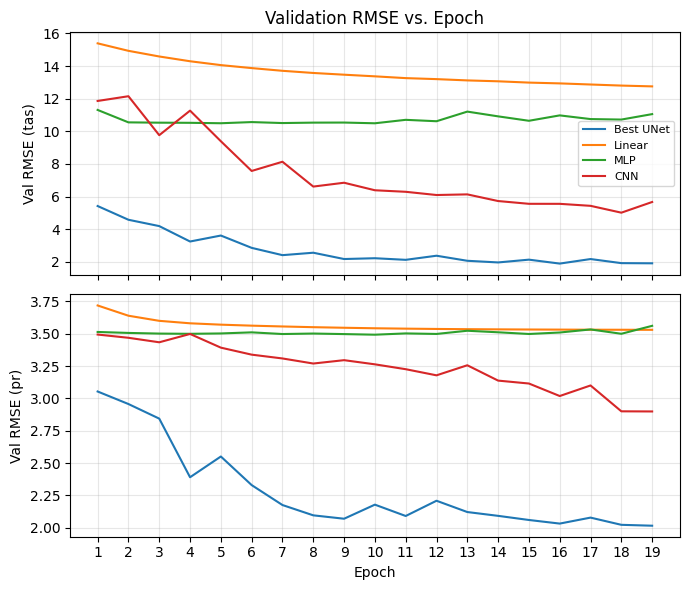

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

for label, df in RAW_LOGS.items():
    ax1.plot(df["epoch"], df["val/tas/rmse"], label=label)
    ax2.plot(df["epoch"], df["val/pr/rmse"],  label=label)

ax1.set_ylabel("Val RMSE (tas)"); ax1.set_title("Validation RMSE vs. Epoch"); ax1.grid(alpha=0.3)
ax2.set_ylabel("Val RMSE (pr)");  ax2.set_xlabel("Epoch");               ax2.grid(alpha=0.3)
ax1.legend(fontsize=8); fig.tight_layout()

save_path = FIG_DIR / "line_val_rmse_vs_epoch.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 4  —  Two-panel Validation-RMSE-vs-Epoch with tiny markers
# ────────────────────────────────────────────────────────────────────────────────
import matplotlib as mpl
mpl.rcParams.update({
    "axes.spines.top"   : False,
    "axes.spines.right" : False,
    "axes.grid"         : True,
    "grid.alpha"        : 0.3,
    "font.size"         : 12,
    "lines.linewidth"   : 2.0,
})

fig, (ax_tas, ax_pr) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 6), sharex=True,
    gridspec_kw={"hspace": 0.25}
)

cmap    = mpl.colormaps["tab10"]
markers = ["o", "s", "^", "D"]               # one per model (extend if needed)
ms      = 3                                  # *very* small marker size

for idx, (label, df) in enumerate(RAW_LOGS.items()):
    color   = cmap(idx)
    marker  = markers[idx % len(markers)]

    # --- tas subplot (solid line) ---
    ax_tas.plot(df["epoch"], df["val/tas/rmse"], color=color,
                label=label, marker=marker, markersize=ms, markevery=1)

    # --- pr subplot (dashed line) ---
    ax_pr .plot(df["epoch"], df["val/pr/rmse"],  color=color,
                label=label, linestyle="--",
                marker=marker, markersize=ms, markevery=1, alpha=0.9)

# Axis styling
ax_tas.set_ylabel("Val RMSE (tas)")
ax_tas.set_title("Validation RMSE vs. Epoch")
ax_tas.legend(fontsize=9, frameon=False)

ax_pr.set_ylabel("Val RMSE (pr)")
ax_pr.set_xlabel("Epoch")

fig.tight_layout()

save_path = FIG_DIR / "line_val_rmse_vs_epoch.png"
fig.savefig(save_path, dpi=300)
print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


/tmp/ipykernel_41744/2828696354.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved → visualization/figures/baseline_vs_unet/line_val_rmse_vs_epoch.png


Saved → visualization/figures/baseline_vs_unet/bar_val_time_mean_rmse.png


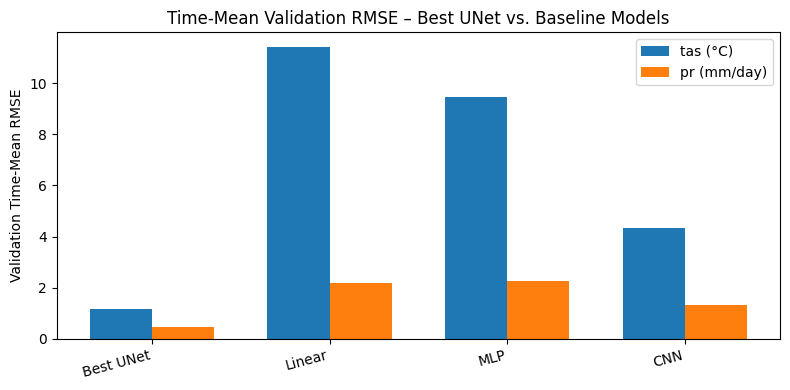

In [14]:
tas_mean = [VAL_ROWS[l]["val/tas/time_mean_rmse"] for l in labels]
pr_mean  = [VAL_ROWS[l]["val/pr/time_mean_rmse"]  for l in labels]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([i - w/2 for i in x], tas_mean, width=w, label="tas (°C)")
ax.bar([i + w/2 for i in x], pr_mean,  width=w, label="pr (mm/day)")

ax.set_xticks(x); ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("Validation Time-Mean RMSE")
ax.set_title("Time-Mean Validation RMSE – Best UNet vs. Baseline Models")
ax.legend(); fig.tight_layout()

save_path = FIG_DIR / "bar_val_time_mean_rmse.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


Saved → visualization/figures/baseline_vs_unet/scatter_val_pr_vs_tas_rmse.png


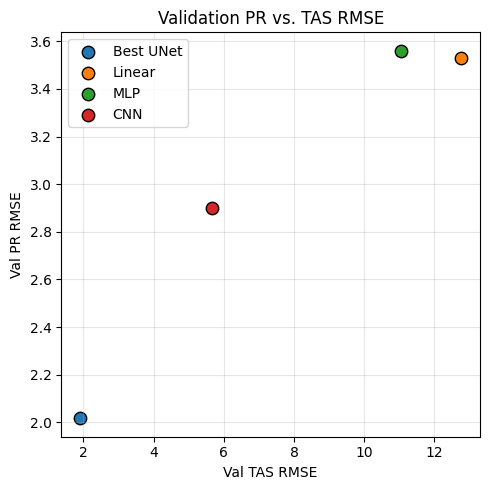

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
for label in labels:
    ax.scatter(VAL_ROWS[label]["val/tas/rmse"],
               VAL_ROWS[label]["val/pr/rmse"],
               s=80, edgecolor="k", label=label)

ax.set_xlabel("Val TAS RMSE"); ax.set_ylabel("Val PR RMSE")
ax.set_title("Validation PR vs. TAS RMSE")
ax.grid(alpha=0.3); ax.legend(); fig.tight_layout()

save_path = FIG_DIR / "scatter_val_pr_vs_tas_rmse.png"
fig.savefig(save_path, dpi=300); print("Saved →", save_path.relative_to(ROOT_DIR))
plt.show()


In [16]:
print("All saved figures:")
for p in sorted(FIG_DIR.glob("*.png")):
    print(" •", p.relative_to(ROOT_DIR))


All saved figures:
 • visualization/figures/baseline_vs_unet/bar_final_test_rmse.png
 • visualization/figures/baseline_vs_unet/bar_val_time_mean_rmse.png
 • visualization/figures/baseline_vs_unet/line_val_rmse_vs_epoch.png
 • visualization/figures/baseline_vs_unet/scatter_val_pr_vs_tas_rmse.png
